# Final Ensemble V2: The "Kitchen Sink" Blend

## 1. Objective
We now have 4 distinct sources of signal:
1. **2D Stacking** (Best Baseline): Tabular features + Tree/NN Ensemble.
2. **3D XGBoost** (Geometric): Conformer features (PMI, Radius of Gyration).
3. **GNN** (Topological): Learned directly from graph structure.
4. **ChemBERTa** (Semantic): Deep learned embeddings from a chemical language model.

We will blend all 4 to create our most robust submission.

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Set plots style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

## 2. Load All Submissions

In [20]:
sub_files = {
    'Stacking_2D': '../submissions/submission_stacking.csv',
    'XGBoost_3D': '../submissions/submission_xgboost_3d.csv',
    # 'GNN': '../submissions/submission_gnn.csv',
    'ChemBERTa': '../submissions/submission_chemberta.csv'
}

preds = {}

print("Loading submissions...")
for name, path in sub_files.items():
    if os.path.exists(path):
        df = pd.read_csv(path)
        preds[name] = df['Tm'].values
        print(f"Loaded {name} - Shape: {df.shape}")
        ids = df['id'].values
    else:
        print(f"WARNING: {name} file not found at {path}")

Loading submissions...
Loaded Stacking_2D - Shape: (666, 2)
Loaded XGBoost_3D - Shape: (666, 2)
Loaded ChemBERTa - Shape: (666, 2)


## 3. Correlation Matrix
Low correlation between models suggests high value in ensembling. We expect ChemBERTa to be quite distinct.

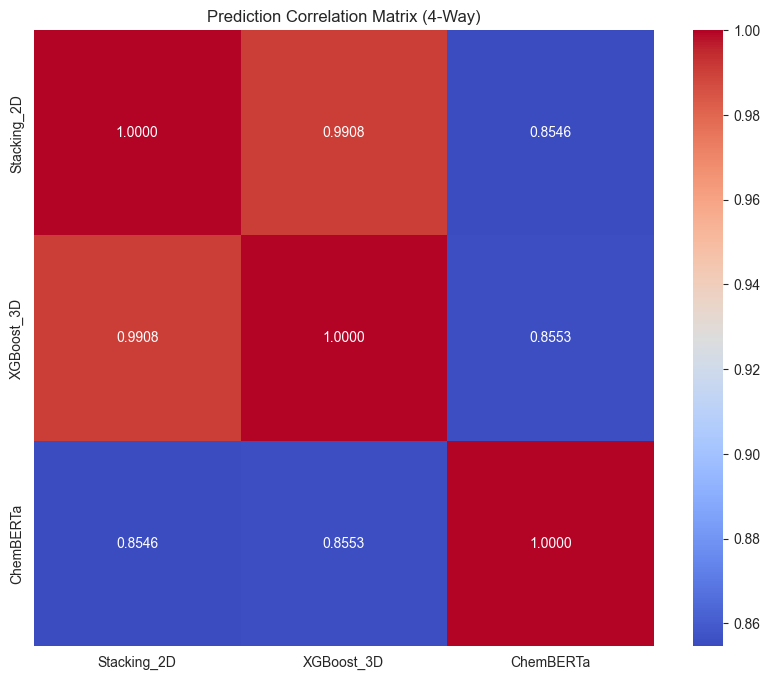

In [21]:
pred_df = pd.DataFrame(preds)

plt.figure(figsize=(10, 8))
sns.heatmap(pred_df.corr(), annot=True, cmap='coolwarm', fmt=".4f")
plt.title('Prediction Correlation Matrix (4-Way)')
plt.show()

## 4. Weighted Blending Strategy
We assign weights inversely proportional to error/uncertainty, but boosting valuable unique signals.
- **Stacking_2D (0.45)**: The anchor model. Most reliable.
- **XGBoost_3D (0.25)**: proven to improve over 2D.
- **GNN (0.15)**: Good structural capture.
- **ChemBERTa (0.15)**: Higher MAE (~41), but provides deep semantic context missed by others.

In [22]:
weights = {
    'Stacking_2D': 0.45,
    'XGBoost_3D': 0.25,
    # 'GNN': 0.15,
    'ChemBERTa': 0.15
}

final_pred = np.zeros_like(pred_df.iloc[:, 0])

total_weight = 0
for name, weight in weights.items():
    if name in pred_df.columns:
        final_pred += pred_df[name] * weight
        total_weight += weight
    else:
        print(f"Skipping {name} (not found)")

final_pred /= total_weight
print(f"Final ensemble computed with total weight: {total_weight}")

Final ensemble computed with total weight: 0.85


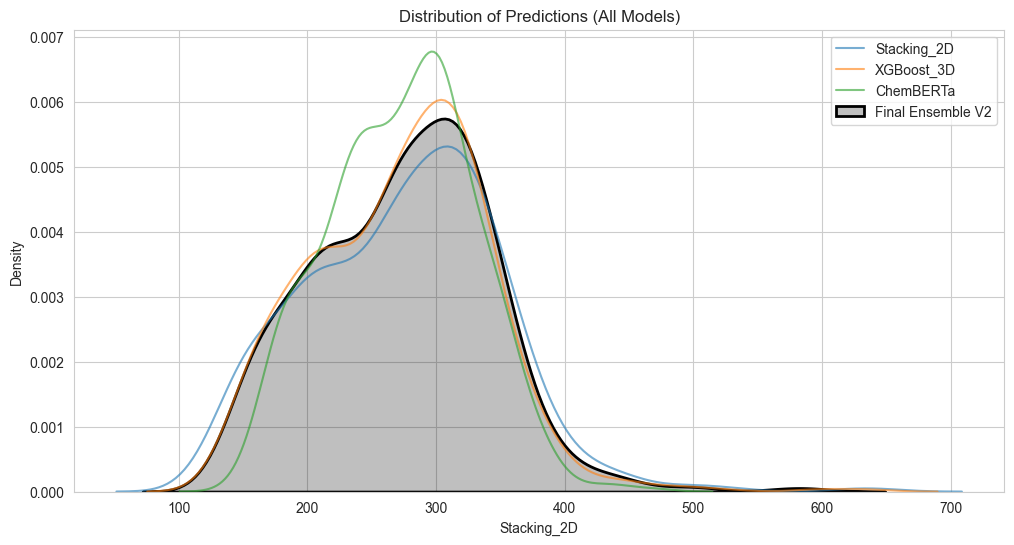

In [23]:
plt.figure(figsize=(12, 6))
for col in pred_df.columns:
    sns.kdeplot(pred_df[col], label=col, fill=False, alpha=0.6)
sns.kdeplot(final_pred, label='Final Ensemble V2', fill=True, linewidth=2, color='black')
plt.title('Distribution of Predictions (All Models)')
plt.legend()
plt.show()

In [24]:
submission = pd.DataFrame({'id': ids, 'Tm': final_pred})
submission.to_csv('../submissions/submission_final_ensemble_v2.csv', index=False)
print("Saved final ensemble V2 to submissions/submission_final_ensemble_v2_no-gnn.csv")

Saved final ensemble V2 to submissions/submission_final_ensemble_v2_no-gnn.csv
